In [37]:
import numpy as np
import pandas as pd
import statistics
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgbm
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve
from sklearn.svm import SVC
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score

In [2]:
df = pd.read_csv("application_train.csv")

In [3]:
features=['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_TYPE_SUITE','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS']

In [4]:
df = df[['TARGET']+features]

In [5]:
df['NAME_CONTRACT_TYPE'] = df['NAME_CONTRACT_TYPE'].replace( { 'Cash loans':1,'Revolving loans':0 })
df['CODE_GENDER'] = df['CODE_GENDER'].replace( { 'F':1,'M':0, 'XNA':-1 } )
df['FLAG_OWN_CAR'] = df['FLAG_OWN_CAR'].replace( { 'N':1,'Y':0 } )
df['FLAG_OWN_REALTY'] = df['FLAG_OWN_REALTY'].replace( { 'Y':1,'N':0 } )
df['NAME_TYPE_SUITE'] = df['NAME_TYPE_SUITE'].replace( { 'Unaccompanied':0,'Family':1,'Spouse, partner':2,'Children':3,'Other_B':4,'Other_A':5,'Group of people':6} ).fillna(-1)
df['NAME_INCOME_TYPE'] = df['NAME_INCOME_TYPE'].replace( { 'Working':0,'Commercial associate':1,'Pensioner':2,'State servant':3,'Unemployed':4,'Student':5,'Businessman':6,'Maternity leave':7} ).fillna(-1)
df['NAME_EDUCATION_TYPE'] = df['NAME_EDUCATION_TYPE'].replace( { 'Secondary / secondary special':0,'Higher education':1,'Incomplete higher':2,'Lower secondary':3,'Academic degree':4} ).fillna(-1)
df['NAME_FAMILY_STATUS'] = df['NAME_FAMILY_STATUS'].replace( { 'Married':0,'Single / not married':1,'Civil marriage':2,'Separated':3,'Widow':4,'Unknown':5} ).fillna(-1)

In [6]:
cat_features = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS']

In [7]:
# Input_x_Features.
X = df[features]
# Input_ y_Target_Variable.
y = df['TARGET']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)

In [9]:
train_set = lgbm.Dataset(X_train,label=y_train, params={'verbose':-1})
valid_set = lgbm.Dataset(X_test,label=y_test, params={'verbose':-1})

0) Взять три гиперпараметра для градиентного бустинга, и для каждого проварьировать один из них, фиксируя остальные. Построить графики зависимости метрики на кросс-валидации от параметра. Прокомментируйте, какие параметры и как влияют на переобучение.

In [10]:
#lr stands for learning rate
params = {'num_leaves':31,
          'learning_rate':0.1,
          'max_depth': 4,
          'metric':['auc'],
          'objective': 'binary',
          'verbose': -1
              }

auc_lr_list = []
lr_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
for lr in lr_list: 
    params['learning_rate'] = lr
    cv_model = lgbm.cv(params, train_set, categorical_feature=cat_features)
    #val_model=lgbm.train(params, train_set, num_boost_round=20,valid_sets=[valid_set],early_stopping_rounds=10,categorical_feature=cat_features)
    auc_lr_list.append(statistics.mean(cv_model['auc-mean']))

/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE']
  _log_warning('categorical_feature in Dataset is overridden.\n'


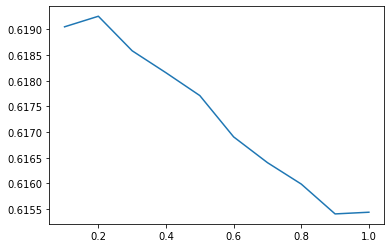

In [11]:
plt.plot(lr_list, auc_lr_list)

Увеличение learning_rate в диапазоне с 0.1 до 1 отрицательно влияет на точность модели на кросс-валидации => положительно влияет на overfitting

In [12]:
#nl stands for num_leaves
params = {'num_leaves':31,
          'learning_rate':0.1,
          'max_depth': 5,
          'metric':['auc'],
          'objective': 'binary',
          'verbose':-1
              }

auc_nl_list = []
nl_list = [25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
for nl in nl_list: 
    params['num_leaves'] = nl
    cv_model = lgbm.cv(params, train_set,categorical_feature=cat_features)
    #val_model=lgbm.train(params, train_set, num_boost_round=20,valid_sets=[valid_set],early_stopping_rounds=10,categorical_feature=cat_features)
    auc_nl_list.append(statistics.mean(cv_model['auc-mean']))

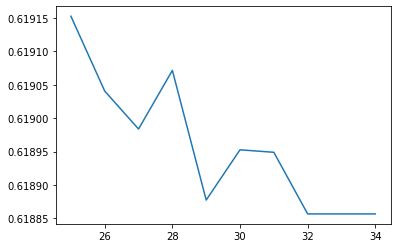

In [13]:
plt.plot(nl_list, auc_nl_list)

Увеличение num_leaves в диапазоне с 25 до 34 в среднем отрицательно влияет на точность модели на кросс-валидации => положительно влияет на overfitting

In [14]:
#md stands for max_depth
params = {'num_leaves':31,
          'learning_rate':0.1,
          'max_depth': 5,
          'metric':['auc'],
          'objective': 'binary',
          'verbose':-1
              }

auc_md_list = []
md_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for md in md_list: 
    params['max_depth'] = md
    cv_model = lgbm.cv(params, train_set,categorical_feature=cat_features)
    #val_model=lgbm.train(params, train_set, num_boost_round=20,valid_sets=[valid_set],early_stopping_rounds=10,categorical_feature=cat_features)
    auc_md_list.append(statistics.mean(cv_model['auc-mean']))

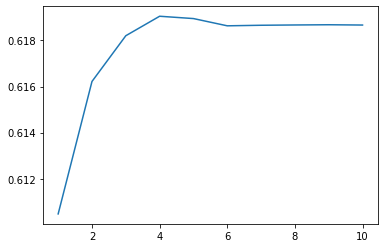

In [16]:
plt.plot(md_list, auc_md_list)

Увеличение max_depth в диапаоне с 1 до 5 положительно влияет и от 5 до 10 влияет отрицательно на точность модели на кросс-валидации => отрицательно max_depth в диапазоне от 1 до 5 отрицательно влияет на overfitting и в диапазоне от 5 до 10 положительно, не не так значительно

1) Сделать с помощью GridSearchCV и RandomizedSearchCV отбор наилучших параметров.

In [17]:
#Сократил список перебираемых параметров из соображений сокращения времени на фиттинг.
#Оставил параметры, которые по графику зависимости "Метрика-Гиперпараметр" - показали наилучшие рез-ты
nl_list = [25, 26, 27, 28, 29]#
md_list = [3, 4, 5, 6, 7]#
lr_list = [0.1, 0.2, 0.3, 0.4]#


parameters = {'num_leaves':nl_list,'max_depth':md_list,
             'learning_rate':lr_list}

clf = LGBMClassifier()


gsearch = GridSearchCV(estimator=clf, param_grid=parameters, scoring='accuracy')
gsearch.fit(X_train, y_train)
print(gsearch.best_params_)

{'learning_rate': 0.3, 'max_depth': 3, 'num_leaves': 25}


In [18]:
#Сократил список перебираемых параметров из соображений сокращения времени на фиттинг.
#Оставил параметры, которые по графику зависимости "Метрика-Гиперпараметр" - показали наилучшие рез-ты
nl_list = [25, 26, 27, 28, 29]#
md_list = [3, 4, 5, 6, 7]#
lr_list = [0.1, 0.2, 0.3, 0.4]#

rs_params = {
        'learning_rate':lr_list,
        'max_depth': md_list,
        'num_leaves': nl_list
}

# Initialize a RandomizedSearchCV object using 5-fold CV-
rs_cv = RandomizedSearchCV(estimator=LGBMClassifier(), param_distributions=rs_params)

# Train on training data-
rs_cv.fit(X_train, y_train)

print(rs_cv.best_params_)

{'num_leaves': 26, 'max_depth': 3, 'learning_rate': 0.2}


2) Построить график feature importance. Какие признаки оказались самыми важными?

In [20]:
val_model=lgbm.train(params, train_set, valid_sets=[valid_set], categorical_feature=cat_features, num_boost_round=10)

[1]	valid_0's auc: 0.615726
[2]	valid_0's auc: 0.615629
[3]	valid_0's auc: 0.616201
[4]	valid_0's auc: 0.616748
[5]	valid_0's auc: 0.617221
[6]	valid_0's auc: 0.617189
[7]	valid_0's auc: 0.617437
[8]	valid_0's auc: 0.618168
[9]	valid_0's auc: 0.618086
[10]	valid_0's auc: 0.618322


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

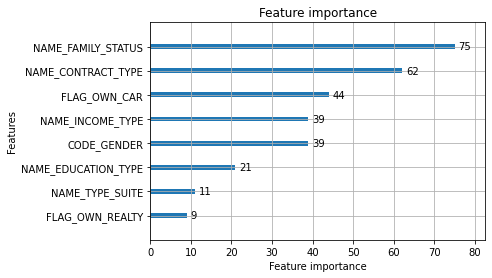

In [22]:
lgbm.plot_importance(val_model)

Самыми важными признаками оказались: NAME_FAMILY_STATUS, NAME_CONTRACT_TYPE, FLAG_OWN_CAR, NAME_INCOME_TYPE 

# Стэкинг

1) Построить стекинг для 5 различных моделей по вашему выбору с разными параметрами. Можете взять любые, например 2 бустинга, 2 случайных леса, лог рег. Записать скор на тестовой выборке.

In [23]:
#Вставлю затюненые параметры по итогам работы GridSearchCV и RandomizedSearchCV
params1 = {'num_leaves':29,
          'learning_rate':0.2,
          'max_depth': 7,
          'metric':['auc'],
          'objective': 'binary'
              }

params2 = {'num_leaves':28,
          'learning_rate':0.3,
          'max_depth': 3,
          'metric':['auc'],
          'objective': 'binary'
              }

models_dict = [('random_forest',RandomForestClassifier(n_estimators=10)),
               ('random_forest1',RandomForestClassifier(n_estimators=5)),
               ('boost1', LGBMClassifier(**params1)),
               ('boost2', LGBMClassifier(**params2)),
               ('log_reg', LogisticRegression())]

clf1 = StackingClassifier(
    estimators=models_dict, final_estimator=LogisticRegression())

#y_score = clf.fit(X_train, y_train).predict_proba(X_test)

Скор на тестовой выборке

In [24]:
clf1.fit(X=X_train, y=y_train)

StackingClassifier(estimators=[('random_forest',
                                RandomForestClassifier(n_estimators=10)),
                               ('random_forest1',
                                RandomForestClassifier(n_estimators=5)),
                               ('boost1',
                                LGBMClassifier(learning_rate=0.2, max_depth=7,
                                               metric=['auc'], num_leaves=29,
                                               objective='binary')),
                               ('boost2',
                                LGBMClassifier(learning_rate=0.3, max_depth=3,
                                               metric=['auc'], num_leaves=28,
                                               objective='binary')),
                               ('log_reg', LogisticRegression())],
                   final_estimator=LogisticRegression())

Убираю модель 'random_forest2'

In [25]:
models_dict = [
               ('random_forest1',RandomForestClassifier(n_estimators=5)),
               ('boost2', LGBMClassifier(**params2)),
               ('boost1', LGBMClassifier(**params1)),
               ('log_reg', LogisticRegression())]

clf2 = StackingClassifier(
    estimators=models_dict, final_estimator=LogisticRegression())

In [26]:
clf2.fit(X=X_train, y=y_train)

StackingClassifier(estimators=[('random_forest1',
                                RandomForestClassifier(n_estimators=5)),
                               ('boost2',
                                LGBMClassifier(learning_rate=0.3, max_depth=3,
                                               metric=['auc'], num_leaves=28,
                                               objective='binary')),
                               ('boost1',
                                LGBMClassifier(learning_rate=0.2, max_depth=7,
                                               metric=['auc'], num_leaves=29,
                                               objective='binary')),
                               ('log_reg', LogisticRegression())],
                   final_estimator=LogisticRegression())

In [46]:
roc_auc_score(y_test, clf1.decision_function(X_test))

0.6206853436328497

In [47]:
roc_auc_score(y_test, clf2.decision_function(X_test))

0.6207226723085468

Скор немного вырос